## Objectives

- Use validation set to report results
- Note these are two different experiments with two different datasets

- Test DF-detector vs. megadetector using DF-classifier
    - confidence_threshold = 0.2 (find source for this)
    - Use full dataset
    - Precision/recall/F1 for animal/human/vehicle/empty (do wild boar deep verification)

- With megadetector, test DF-fine-tuned:
    - Dataset where megadetector detected an animal
    - Precision/recall/F1 for all species, plus total
    - 5 epochs, lr1e-5
    - 5 epochs, lr1e-5 & 5 epochs, wb loss

## Detect Test Rig

### DeepFaune's Yolov8s model

In [ ]:
import pandas as pd
from ultralytics import YOLO
from tqdm import tqdm

# Define paths
excel_path = "/home/tom-ratsakatika/VSCode/camera-traps/data/structured_data_with_deepfaune_updated.xlsx"
model_path = "../models/deepfaune-yolov8s_960.pt"

# Load the Excel file
df = pd.read_excel(excel_path)

# Ensure the path components are treated as strings
df['Original Path'] = df['Original Path'].astype(str)
df['Original Filename'] = df['Original Filename'].astype(str)
df['File Extension'] = df['File Extension'].astype(str)

# Combine file path, name, and extension to get the full image path
df['Full Path'] = df['Original Path'] + '/' + df['Original Filename'] + '.' + df['File Extension']

# Load the YOLOv8 model
model = YOLO(model_path, verbose=False)
model.conf = 0.2  # Set confidence threshold

# Suppress YOLO logs
import logging
logging.getLogger('ultralytics').setLevel(logging.WARNING)

# Function to process a batch of images
def process_batch(image_paths):
    results = model(image_paths)
    batch_detections = []
    batch_confidences = []
    for result in results:
        if result.boxes is None or len(result.boxes) == 0:
            batch_detections.append("Empty")
            batch_confidences.append(0)
        else:
            highest_conf_detection = max(result.boxes, key=lambda x: x.conf[0])  # Access the highest confidence detection
            category = highest_conf_detection.cls[0].item()  # Access the class/category index
            confidence = highest_conf_detection.conf[0].item()  # Access the confidence score
            
            if category == 0:
                batch_detections.append("Animal")
            elif category == 1:
                batch_detections.append("Human")
            elif category == 2:
                batch_detections.append("Vehicle")
            else:
                batch_detections.append("Unknown")
                
            batch_confidences.append(confidence)
    return batch_detections, batch_confidences

# Process images in batches with progress bar
batch_size = 32  # 32 = 3.6GB of VRAM
image_paths = df['Full Path'].tolist()
batch_results = []
batch_confidences = []

# Initialize progress bar
with tqdm(total=len(image_paths), desc="Processing images", unit="image") as pbar:
    for i in range(0, len(image_paths), batch_size):
        batch = image_paths[i:i + batch_size]
        detections, confidences = process_batch(batch)
        batch_results.extend(detections)
        batch_confidences.extend(confidences)
        pbar.update(len(batch))

# Add or update the 'DF_Detector' and 'DF_Detector_Conf' columns in the DataFrame
df['DF_Detector'] = batch_results
df['DF_Detector_Conf'] = batch_confidences

# Save the updated DataFrame back to Excel
df.to_excel(excel_path, index=False)


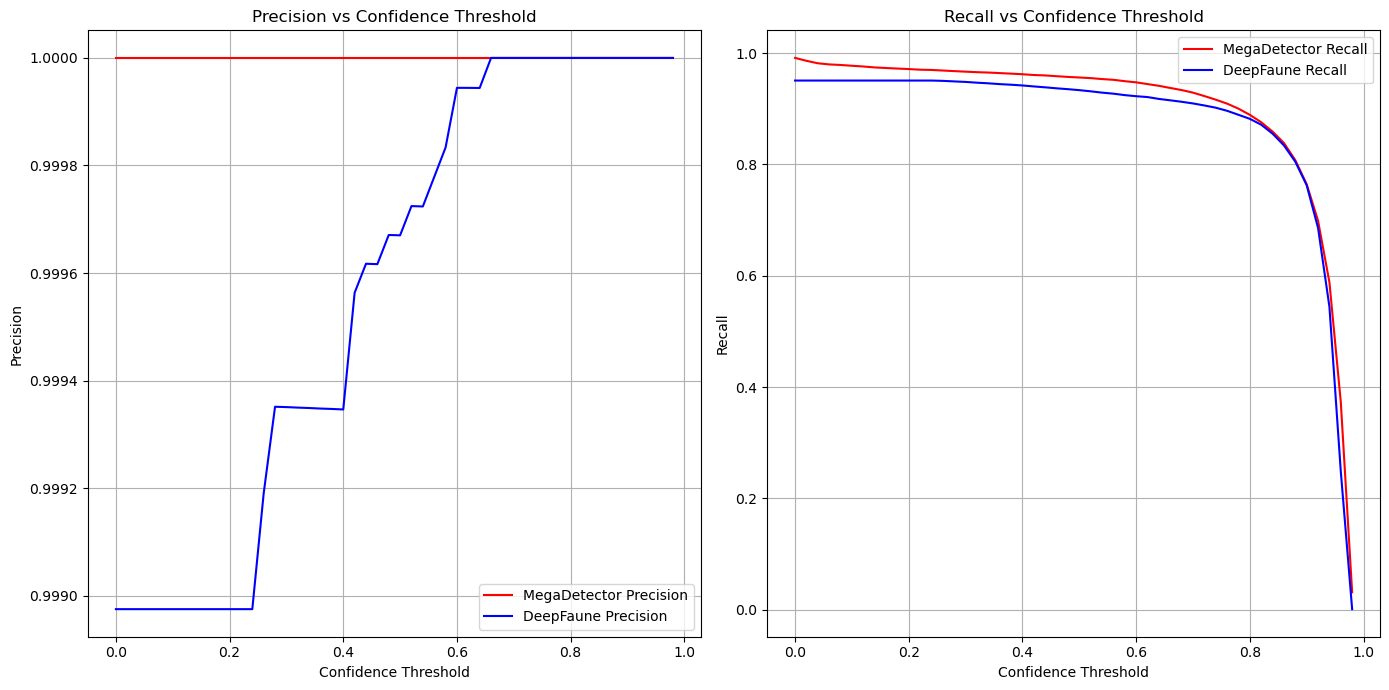

,Threshold,MegaDetector_Precision,MegaDetector_Recall,MegaDetector_F1,DeepFaune_Precision,DeepFaune_Recall,DeepFaune_F1
0,0.00,1.0,0.991327,0.995644,0.998975,0.950629,0.974203
10,0.20,1.0,0.971260,0.985420,0.998975,0.950629,0.974203
20,0.40,1.0,0.961971,0.980617,0.999347,0.941801,0.969721
30,0.60,1.0,0.947395,0.972987,0.999944,0.922504,0.959665
40,0.80,1.0,0.889043,0.941263,1.000000,0.881858,0.937220
49,0.98,1.0,0.031203,0.060519,1.000000,0.000975,0.001948


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the Excel file
excel_path = "/home/tom-ratsakatika/VSCode/camera-traps/data/structured_data_with_deepfaune_updated.xlsx"
df = pd.read_excel(excel_path)

# Filter out rows where Ground_Truth_Detect has no value ("")
df = df[df['Ground_Truth_Detect'] != ""]

# Function to map labels to "Empty" and "Not Empty"
def map_labels(label):
    if label == "Empty":
        return "Empty"
    else:
        return "Not Empty"

# Apply the label mapping
df['Ground_Truth_Detect'] = df['Ground_Truth_Detect'].apply(map_labels)
df['MegaDetector'] = df['MegaDetector'].apply(map_labels)
df['DF_Detector'] = df['DF_Detector'].apply(map_labels)

# Function to apply the confidence threshold logic
def apply_threshold(row, detector_conf, detector_label, threshold):
    if row[detector_conf] <= threshold:
        return "Empty"
    else:
        return row[detector_label]

# Function to calculate precision, recall, and F1 score at different thresholds
def calculate_metrics(df, detector_label, detector_conf, ground_truth_label):
    thresholds = np.arange(0, 1.00, 0.02)
    precision = []
    recall = []
    f1_scores = []
    
    for threshold in thresholds:
        # Apply threshold logic
        df['Filtered_Label'] = df.apply(lambda row: apply_threshold(row, detector_conf, detector_label, threshold), axis=1)
        
        # Calculate TP, FP, FN
        TP = ((df['Filtered_Label'] == 'Not Empty') & (df[ground_truth_label] == 'Not Empty')).sum()
        FP = ((df['Filtered_Label'] == 'Not Empty') & (df[ground_truth_label] == 'Empty')).sum()
        FN = ((df['Filtered_Label'] == 'Empty') & (df[ground_truth_label] == 'Not Empty')).sum()
        
        # Calculate precision and recall
        precision_val = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall_val = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        # Calculate F1 score
        f1_val = 2 * (precision_val * recall_val) / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0
        
        precision.append(precision_val)
        recall.append(recall_val)
        f1_scores.append(f1_val)
    
    return thresholds, precision, recall, f1_scores

# Calculate metrics for MegaDetector
thresholds, mega_precision, mega_recall, mega_f1 = calculate_metrics(df, 'MegaDetector', 'MegaDetector_Conf', 'Ground_Truth_Detect')

# Calculate metrics for DeepFaune
_, df_precision, df_recall, df_f1 = calculate_metrics(df, 'DF_Detector', 'DF_Detector_Conf', 'Ground_Truth_Detect')

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Precision Plot
ax1.plot(thresholds, mega_precision, 'r-', label='MegaDetector Precision')
ax1.plot(thresholds, df_precision, 'b-', label='DeepFaune Precision')
ax1.set_xlabel('Confidence Threshold')
ax1.set_ylabel('Precision')
ax1.set_title('Precision vs Confidence Threshold')
ax1.legend()
ax1.grid(True)

# Recall Plot
ax2.plot(thresholds, mega_recall, 'r-', label='MegaDetector Recall')
ax2.plot(thresholds, df_recall, 'b-', label='DeepFaune Recall')
ax2.set_xlabel('Confidence Threshold')
ax2.set_ylabel('Recall')
ax2.set_title('Recall vs Confidence Threshold')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Threshold': thresholds,
    'MegaDetector_Precision': mega_precision,
    'MegaDetector_Recall': mega_recall,
    'MegaDetector_F1': mega_f1,
    'DeepFaune_Precision': df_precision,
    'DeepFaune_Recall': df_recall,
    'DeepFaune_F1': df_f1
})

# Filter the DataFrame to include only the specified thresholds
results_df = results_df[results_df['Threshold'].isin([0.0, 0.2, 0.4, 0.6, 0.8, 0.98])]

# Print the results table
results_df
